# Process SASSIE ocean model granules

In [7]:
import tarfile
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
import netCDF4 as nc4
from datetime import datetime, timedelta

import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


## import ECCO utils
import sys
sys.path.append('/Users/mzahn/github_others/ECCOv4-py')
import ecco_v4_py as ecco

ECCO github docs: https://github.com/ECCO-GROUP/ECCOv4-py/blob/master/ecco_v4_py/netcdf_product_generation.py

*Info from Ian/Mike:*

TIME<br>
data.cal start time is 1992-01-01<br>
Start time of the model is 5790000 (22.0319 years after 1992-01-01)<br>
Which is 2014-01-06T16:00:00<br>
Model simulation goes to around end of 2021<br>

FILES<br>
Each gz file has 14 files, each for one day<br>
199 (files)*14 (days per gz file) = 2,786 (days)/365 (days per year)= 7.6329 years

From *.meta file:
 nDims = [   2 ];
 dimList = [
         40,         1,        40,
     102600,         1,    102600
 ];
 dataprec = [ 'float32' ];
 nrecords = [          3 ];
 timeStepNumber = [    5810400 ];
 timeInterval = [  6.971616000000E+08  6.972480000000E+08 ];
 missingValue = [ -9.99000000000000E+02 ];
 nFlds = [    3 ];
 fldList = {
 'SIarea  ' 'SIheff  ' 'SIhsnow '
 };


## ECCO routines 

### routines to convert between SASSIE N1 faces and compact

In [13]:
def load_sassie_N1_field(file_dir, fname, nk=1, skip=0):
    num_cols = 680*4 + 1080
    num_rows = 1080
    
    time_level = int(fname.split('.data')[0].split('.')[-1])
    
    tmp_compact = ecco.load_binary_array(file_dir, fname, \
                                    num_rows, num_cols, nk=nk, skip=skip, filetype='>f4')

    return tmp_compact, time_level

In [15]:
def sassie_n1_compact_to_faces_2D(sassie_n1_compact):
    sassie_faces = dict()
    n = 680
    
    # Face 1 
    start_row = 0
    end_row = n
    sassie_faces[1] = sassie_n1_compact[start_row:end_row,:]

    # Face 2
    start_row = end_row
    end_row = start_row + n

    sassie_faces[2] = sassie_n1_compact[start_row:end_row,:]
    
    # Face 3
    start_row = end_row
    end_row = start_row + 1080
    sassie_faces[3] = sassie_n1_compact[start_row:end_row:,:]
    
    #Face 4
    start_row = end_row
    end_row = end_row + 680
    sassie_faces[4] = sassie_n1_compact[start_row:end_row].reshape(1080, n)

    #Face 5
    start_row = end_row
    end_row = end_row + 680
    sassie_faces[5] = sassie_n1_compact[start_row:end_row].reshape(1080, n)

    return sassie_faces

In [17]:
def sassie_n1_compact_to_faces_3D(sassie_n1_compact):
    sassie_faces = dict()
    n = 680
    
    # Face 1 
    start_row = 0
    end_row = n
    sassie_faces[1] = sassie_n1_compact[:,start_row:end_row,:]

    # Face 2
    start_row = end_row
    end_row = start_row + n
    sassie_faces[2] = sassie_n1_compact[:,start_row:end_row,:]
    
    # Face 3
    start_row = end_row
    end_row = start_row + 1080
    sassie_faces[3] = sassie_n1_compact[:,start_row:end_row:,:]
    
    #Face 4
    start_row = end_row
    end_row = end_row + 680
    sassie_faces[4] = sassie_n1_compact[:,start_row:end_row].reshape(90, 1080, n)

    #Face 5
    start_row = end_row
    end_row = end_row + 680
    sassie_faces[5] = sassie_n1_compact[:,start_row:end_row].reshape(90, 1080, n)

    return sassie_faces

In [19]:
## function to slice small pieces from Faces 1 and 4 and combine them to the Arctic Face 3
def combine_sassie_N1_faces_to_HHv2_2D(face_arr):
    # dimensions of the final Arctic HH field. 535+185+1080=1800
    new_arr = np.zeros((1080, 1800)) 
    # cut out sections we want and assign them to location on HH
    new_arr[:, 185:185 + 1080] = face_arr[3]
    # rotate Face 1 to line up with orientation of Face 3
    new_arr[:, 0:185] = np.flipud(face_arr[1][-185:,:].T) # flip and transpose
    new_arr[:, 185 + 1080:] = face_arr[4][:,:535]

    new_arr = np.rot90(new_arr,2) # rotate it 180 so Greenland/AK are on bottom
    return new_arr

In [21]:
## function to slice small pieces from Faces 1 and 4 and combine them to the Arctic Face 3
def combine_sassie_N1_faces_to_HHv2_3D(face_arr):
    # dimensions of the final Arctic HH field. 535+185+1080=1800 ; 90 vertical levels
    new_arr = np.zeros((90, 1080, 1800)) 
    # cut out sections we want and assign them to location on HH
    new_arr[:, :, 185:185 + 1080] = face_arr[3]
    # rotate Face 1 to line up with orientation of Face 3
    new_arr[:, :, 0:185] = np.transpose(face_arr[1][:,-185:,::-1],axes=(0,2,1)) # flip and transpose
    new_arr[:, :, 185 + 1080:] = face_arr[4][:,:,:535]

    new_arr = np.rot90(new_arr,2,axes=(1,2)) # rotate it 180 so Greenland/AK are on bottom
    return new_arr

In [23]:
def plot_sassie_HHv2_3D(face_arr, depth_level=0, vmin=None, vmax=None,\
    cmap='jet', axs = None, \
    show_colorbar=True):

    tmp = combine_sassie_N1_faces_to_HHv2_3D(face_arr)

    if vmin == None:
        vmin = np.min(tmp)
    if vmax == None:
        vmax = np.max(tmp)

    if axs == None:
        plt.imshow(tmp[depth_level,:,:], origin='lower', interpolation='none',vmin=vmin,vmax=vmax, cmap=cmap)
        if show_colorbar:
            plt.colorbar()

    else:
        im1 = axs.imshow(tmp[depth_level,:,:], origin='lower', interpolation='none',vmin=vmin,vmax=vmax, cmap=cmap)
        fig = plt.gcf()
        if show_colorbar:
            fig.colorbar(im1, ax=axs)

In [25]:
def make_2D_HHv2_da(field_HH, model_grid_ds, da_name):
    tmp_da = xr.DataArray(field_HH, dims=['j','i'],\
                            coords={'XC': (('j','i'), model_grid_ds.XC.values),\
                                    'YC': (('j','i'), model_grid_ds.YC.values)})
    
    tmp_da.name = da_name
    # tmp_da = add_geo_metadata(tmp_da)
    
    return tmp_da

In [27]:
def make_3D_HHv2_da(field_HH, model_grid_ds, timestamp, da_name='NAME', k_face='center'):
    if k_face == 'center':
        tmp_da = xr.DataArray([field_HH], dims=['time', 'k','j','i'],\
                                coords={'XC': (('j','i'), model_grid_ds.XC.values),\
                                        'YC': (('j','i'), model_grid_ds.YC.values),\
                                        'Z': (('k'), model_grid_ds.Z.values),\
                                        'Zu':(('k'),model_grid_ds.Zu.values),\
                                        'Zl':(('k'),model_grid_ds.Zl.values),\
                                        'time':(('time'),timestamp)})
        tmp_da['k'].attrs['axis']  = 'Z'

    elif k_face == 'top':
        tmp_da = xr.DataArray([field_HH], dims=['time','k_l','j','i'],\
                                coords={'XC': (('j','i'), model_grid_ds.XC.values),\
                                        'YC': (('j','i'), model_grid_ds.YC.values),\
                                        'Z': (('k'), model_grid_ds.Z.values),\
                                        'Zu':(('k'),model_grid_ds.Zu.values),\
                                        'Zl':(('k'),model_grid_ds.Zl.values),\
                                        'time':(('time'),timestamp)})
        tmp_da['k_l'].attrs['axis']  = 'Z'

    elif k_face == 'bottom':
        tmp_da = xr.DataArray([field_HH], dims=['time','k_u','j','i','time'],\
                                coords={'XC': (('j','i'), model_grid_ds.XC.values),\
                                        'YC': (('j','i'), model_grid_ds.YC.values),\
                                        'Z': (('k'), model_grid_ds.Z.values),\
                                        'Zu':(('k'),model_grid_ds.Zu.values),\
                                        'Zl':(('k'),model_grid_ds.Zl.values),\
                                        'time':(('time'),timestamp)})
        tmp_da['k_u'].attrs['axis']  = 'Z'


    tmp_da['Z'].attrs['long_name'] = 'grid cell depth at center'
    tmp_da['Zu'].attrs['long_name'] = 'grid cell depth at bottom'
    tmp_da['Zl'].attrs['long_name'] = 'grid cell depth at top'

    tmp_da['Z'].attrs['units'] = 'm'
    tmp_da['Zl'].attrs['units'] = 'm'
    tmp_da['Zu'].attrs['units'] = 'm'

    tmp_da.name = da_name
 #   tmp_da = add_geo_metadata(tmp_da)

    return tmp_da

In [29]:
def timestamp_from_iter_num(iter_num):
    """
    takes the model iteration that was pulled from the data's filename and converts it to its equivalent datetime
    """
    ## Start time of the model is 5790000 (22.0319 years after 1992-01-01)
    ## there are 120 seconds for each iteration and 86400 seconds per day
    ## take the iteration number, convert to seconds, and calculate number of days since start of model
    
    num_days_since_start = iter_num*120 / 86400 ## divide iter_number by 86400 which is equal to the number of seconds in a day
    model_start_time = datetime(1992,1,1) # data.cal start time is 1992-01-01
    
    timestamp = np.array([model_start_time + timedelta(days=num_days_since_start)], dtype='datetime64[ns]')
    
    return timestamp

In [33]:
def create_encoding(ecco_ds, output_array_precision = np.float32):
    
    # Create NetCDF encoding directives
    # ---------------------------------------------
    print('\n... creating variable encodings')
    # ... data variable encoding directives
    
    # Define fill values for NaN
    if output_array_precision == np.float32:
        netcdf_fill_value = nc4.default_fillvals['f4']

    elif output_array_precision == np.float64:
        netcdf_fill_value = nc4.default_fillvals['f8']
    
    dv_encoding = dict()
    for dv in ecco_ds.data_vars:
        dv_encoding[dv] =  {'zlib':True, \
                            'complevel':5,\
                            'shuffle':True,\
                            '_FillValue':netcdf_fill_value}

    # ... coordinate encoding directives
    print('\n... creating coordinate encodings')
    coord_encoding = dict()
    for coord in ecco_ds.coords:
        # set default no fill value for coordinate
        if output_array_precision == np.float32:
            coord_encoding[coord] = {'_FillValue':None, 'dtype':'float32'}
        elif output_array_precision == np.float64:
            coord_encoding[coord] = {'_FillValue':None, 'dtype':'float64'}

        # force 64 bit ints to be 32 bit ints
        if (ecco_ds[coord].values.dtype == np.int32) or \
           (ecco_ds[coord].values.dtype == np.int64) :
            coord_encoding[coord]['dtype'] ='int32'

        # fix encoding of time
        if coord == 'time' or coord == 'time_bnds':
            coord_encoding[coord]['dtype'] ='int32'

            if 'units' in ecco_ds[coord].attrs:
                # apply units as encoding for time
                coord_encoding[coord]['units'] = ecco_ds[coord].attrs['units']
                # delete from the attributes list
                del ecco_ds[coord].attrs['units']

        elif coord == 'time_step':
            coord_encoding[coord]['dtype'] ='int32'

    # ... combined data variable and coordinate encoding directives
    encoding = {**dv_encoding, **coord_encoding}

    return encoding

### Run test for tr_diff_x_day_mean

In [41]:
##  'DFxE_SLT' 'DFxE_TH ' 'DFyE_SLT' 'DFyE_TH '

In [75]:
data_dir = Path('/Users/mzahn/data/SASSIE/SASSIE_examples/daily_avg/tr_diff_x_day_mean/tr_diff_x_day_mean.0005800000/')
filename = "tr_diff_x_day_mean.0005806080.data"

DFxE_SLT_compact, DFxE_SLT_level = load_sassie_N1_field(data_dir, filename, nk=90, skip=0)
DFxE_TH_compact, DFxE_TH_level = load_sassie_N1_field(data_dir, filename, nk=90, skip=0)
DFyE_SLT_compact, DFyE_SLT_level = load_sassie_N1_field(data_dir, filename, nk=90, skip=0)
DFyE_TH_SLT_compact, DFyE_TH_SLT_level = load_sassie_N1_field(data_dir, filename, nk=90, skip=0)

load_binary_array: loading file /Users/mzahn/data/SASSIE/SASSIE_examples/daily_avg/tr_diff_x_day_mean/tr_diff_x_day_mean.0005800000/tr_diff_x_day_mean.0005806080.data
load_binary_array: data array shape  (90, 3800, 1080)
load_binary_array: data array type  >f4
load_binary_array: loading file /Users/mzahn/data/SASSIE/SASSIE_examples/daily_avg/tr_diff_x_day_mean/tr_diff_x_day_mean.0005800000/tr_diff_x_day_mean.0005806080.data
load_binary_array: data array shape  (90, 3800, 1080)
load_binary_array: data array type  >f4
load_binary_array: loading file /Users/mzahn/data/SASSIE/SASSIE_examples/daily_avg/tr_diff_x_day_mean/tr_diff_x_day_mean.0005800000/tr_diff_x_day_mean.0005806080.data
load_binary_array: data array shape  (90, 3800, 1080)
load_binary_array: data array type  >f4
load_binary_array: loading file /Users/mzahn/data/SASSIE/SASSIE_examples/daily_avg/tr_diff_x_day_mean/tr_diff_x_day_mean.0005800000/tr_diff_x_day_mean.0005806080.data
load_binary_array: data array shape  (90, 3800, 10

In [76]:
print(np.any(DFxE_SLT_compact != 0))
print(np.any(DFxE_TH_compact != 0))
print(np.any(DFyE_SLT_compact != 0))
print(np.any(DFyE_TH_SLT_compact != 0))

False
False
False
False


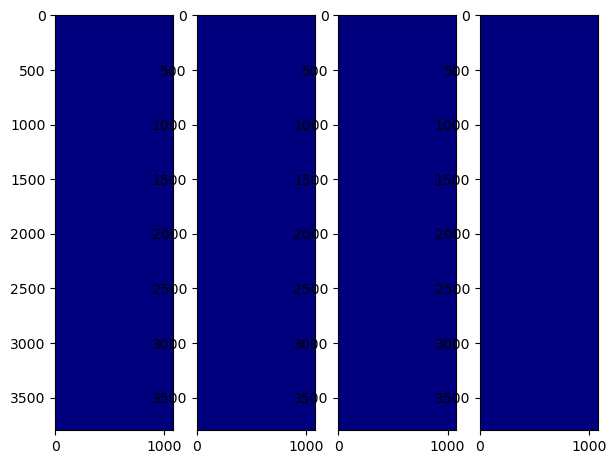

In [78]:
fig,axs = plt.subplots(1,4, figsize=[7,6])
axs[0].imshow(DFxE_SLT_compact[0,:,:], origin='lower', cmap='jet')
axs[1].imshow(DFxE_TH_compact[0,:,:], origin='lower', cmap='jet')
axs[2].imshow(DFyE_SLT_compact[0,:,:], origin='lower', cmap='jet')
axs[3].imshow(DFyE_TH_SLT_compact[0,:,:], origin='lower', cmap='jet')

for ax in axs:
    ax.invert_yaxis()

In [47]:
data_dir = Path('/Users/mzahn/data/SASSIE/SASSIE_examples/daily_avg/tr_diff_x_day_mean/tr_diff_x_day_mean.0006110000/')
filename = "tr_diff_x_day_mean.0006119280.data"

DFxE_SLT_compact, DFxE_SLT_level = load_sassie_N1_field(data_dir, filename, nk=90, skip=0)
DFxE_TH_compact, DFxE_TH_level = load_sassie_N1_field(data_dir, filename, nk=90, skip=0)
DFyE_SLT_compact, DFyE_SLT_level = load_sassie_N1_field(data_dir, filename, nk=90, skip=0)
DFyE_TH_SLT_compact, DFyE_TH_SLT_level = load_sassie_N1_field(data_dir, filename, nk=90, skip=0)

load_binary_array: loading file /Users/mzahn/data/SASSIE/SASSIE_examples/daily_avg/tr_diff_x_day_mean/tr_diff_x_day_mean.0006110000/tr_diff_x_day_mean.0006119280.data
load_binary_array: data array shape  (90, 3800, 1080)
load_binary_array: data array type  >f4
load_binary_array: loading file /Users/mzahn/data/SASSIE/SASSIE_examples/daily_avg/tr_diff_x_day_mean/tr_diff_x_day_mean.0006110000/tr_diff_x_day_mean.0006119280.data
load_binary_array: data array shape  (90, 3800, 1080)
load_binary_array: data array type  >f4
load_binary_array: loading file /Users/mzahn/data/SASSIE/SASSIE_examples/daily_avg/tr_diff_x_day_mean/tr_diff_x_day_mean.0006110000/tr_diff_x_day_mean.0006119280.data
load_binary_array: data array shape  (90, 3800, 1080)
load_binary_array: data array type  >f4
load_binary_array: loading file /Users/mzahn/data/SASSIE/SASSIE_examples/daily_avg/tr_diff_x_day_mean/tr_diff_x_day_mean.0006110000/tr_diff_x_day_mean.0006119280.data
load_binary_array: data array shape  (90, 3800, 10

In [55]:
print(np.any(DFxE_SLT_compact != 0))
print(np.any(DFxE_TH_compact != 0))
print(np.any(DFyE_SLT_compact != 0))
print(np.any(DFyE_TH_SLT_compact != 0))

False
False
False
False


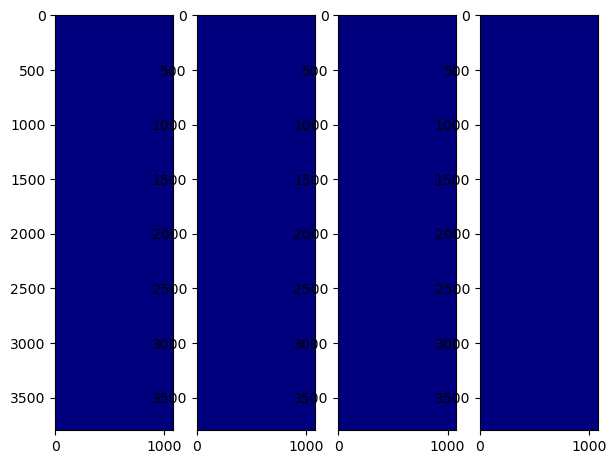

In [51]:
fig,axs = plt.subplots(1,4, figsize=[7,6])
axs[0].imshow(DFxE_SLT_compact[0,:,:], origin='lower', cmap='jet')
axs[1].imshow(DFxE_TH_compact[0,:,:], origin='lower', cmap='jet')
axs[2].imshow(DFyE_SLT_compact[0,:,:], origin='lower', cmap='jet')
axs[3].imshow(DFyE_TH_SLT_compact[0,:,:], origin='lower', cmap='jet')

for ax in axs:
    ax.invert_yaxis()

### Run an example 2D field

Open and process one file

In [13]:
sassie_1080_data_dir = Path('/Users/mzahn/data/SASSIE/SASSIE_examples/')
seaice_filename = 'seaice_state_day_mean/seaice_state_day_mean.0005796720.data'
ocean_2d_filename = 'ocean_state_2D_day_mean/ocean_state_2D_day_mean.0005800320.data'

seaice_compact, seaice_time_level = load_sassie_N1_field(sassie_1080_data_dir, seaice_filename, nk=3)
ocean2d_compact, ocean2d_time_level = load_sassie_N1_field(sassie_1080_data_dir, ocean_2d_filename, nk=3)

load_binary_array: loading file /Users/mzahn/data/SASSIE/SASSIE_examples/seaice_state_day_mean/seaice_state_day_mean.0005796720.data
load_binary_array: data array shape  (3, 3800, 1080)
load_binary_array: data array type  >f4
load_binary_array: loading file /Users/mzahn/data/SASSIE/SASSIE_examples/ocean_state_2D_day_mean/ocean_state_2D_day_mean.0005800320.data
load_binary_array: data array shape  (3, 3800, 1080)
load_binary_array: data array type  >f4


In [268]:
# ETAN is the height of the model's liquid ocean surface
# PHIBOT is model ocean bottom pressure (in m2s-2)
# sIceLoad Sea-ice and snow loading defined as mass of sea-ice & snow over area (kg/m2).

In [270]:
# manually open and inspect files
# data_ocean = np.fromfile('data/ocean_state_2D_day_mean/ocean_state_2D_day_mean.0005800320.data', dtype='>f4') 
# data_seaice = np.fromfile('data/seaice_state_day_mean/seaice_state_day_mean.0005810400.data', dtype='>f4') 

Ocean State 2D

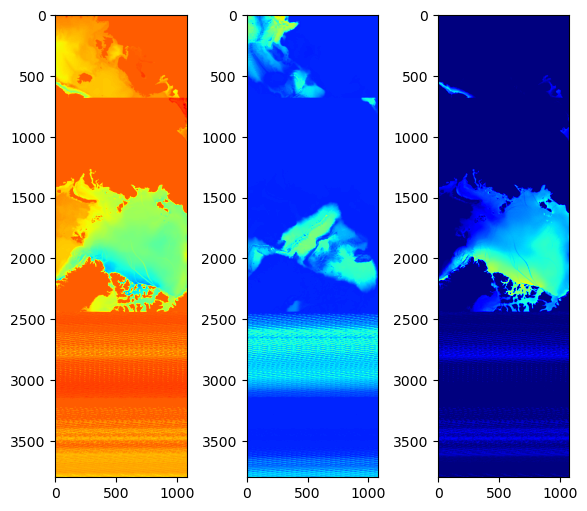

In [15]:
fig,axs = plt.subplots(1,3, figsize=[7,6])
axs[0].imshow(ocean2d_compact[0,:,:], origin='lower', cmap='jet')
axs[1].imshow(ocean2d_compact[1,:,:], origin='lower', cmap='jet')
axs[2].imshow(ocean2d_compact[2,:,:], origin='lower', cmap='jet')

for ax in axs:
    ax.invert_yaxis()

Sea Ice State 2D

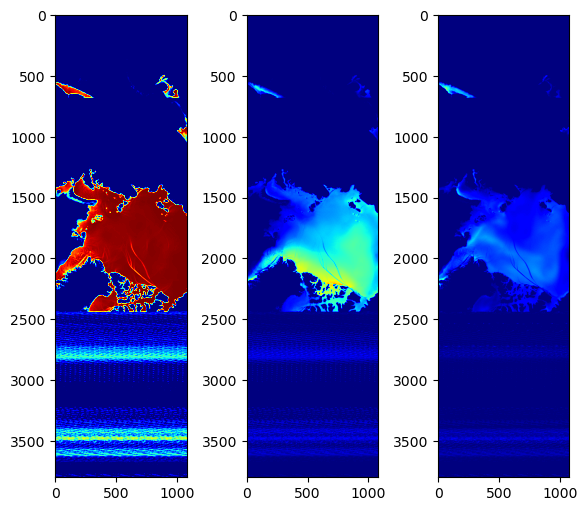

In [64]:
fig,axs = plt.subplots(1,3, figsize=[7,6])
axs[0].imshow(seaice_compact[0,:,:], origin='lower', cmap='jet')
axs[1].imshow(seaice_compact[1,:,:], origin='lower', cmap='jet')
axs[2].imshow(seaice_compact[2,:,:], origin='lower', cmap='jet')

for ax in axs:
    ax.invert_yaxis()

In [17]:
etan_faces     = sassie_n1_compact_to_faces_2D(ocean2d_compact[0,:,:])
phibot_faces   = sassie_n1_compact_to_faces_2D(ocean2d_compact[1,:,:])
SIceload_faces = sassie_n1_compact_to_faces_2D(ocean2d_compact[2,:,:])

SIarea_faces  = sassie_n1_compact_to_faces_2D(seaice_compact[0,:,:])
SIheff_faces  = sassie_n1_compact_to_faces_2D(seaice_compact[1,:,:])
SIhsnow_faces = sassie_n1_compact_to_faces_2D(seaice_compact[2,:,:])

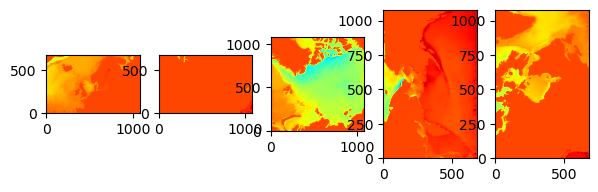

In [68]:
# replot
fig,axs = plt.subplots(1,5, figsize=[7,6])
axs[0].imshow(etan_faces[1], origin='lower', cmap='jet', vmin=-5, vmax=1)
axs[1].imshow(etan_faces[2], origin='lower', cmap='jet', vmin=-5, vmax=1)
axs[2].imshow(etan_faces[3], origin='lower', cmap='jet', vmin=-5, vmax=1)
axs[3].imshow(etan_faces[4], origin='lower', cmap='jet', vmin=-5, vmax=1)
axs[4].imshow(etan_faces[5], origin='lower', cmap='jet', vmin=-5, vmax=1)

# for ax in axs:
#     ax.invert_yaxis()

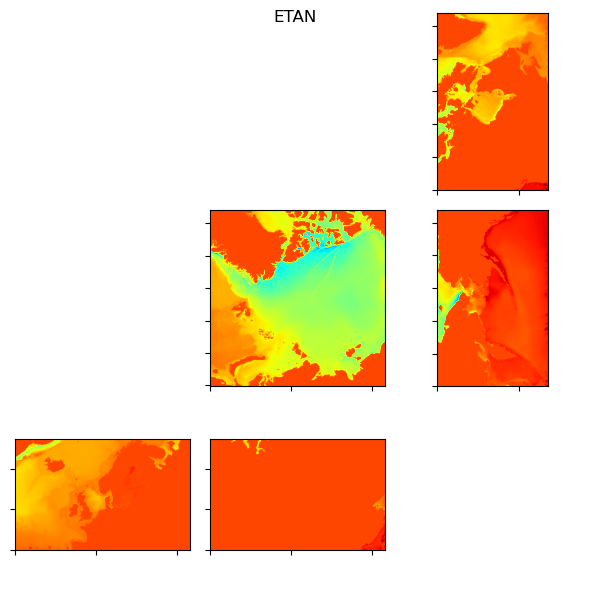

In [70]:
fig,axs = plt.subplots(3,3, figsize=[6,6])
ax = axs.ravel()
ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].imshow(etan_faces[5], origin='lower', cmap='jet', vmin=-5, vmax=1)
ax[3].set_axis_off()
ax[4].imshow(etan_faces[3], origin='lower', cmap='jet', vmin=-5, vmax=1)
ax[5].imshow(etan_faces[4], origin='lower', cmap='jet', vmin=-5, vmax=1)
ax[6].imshow(etan_faces[1], origin='lower', cmap='jet', vmin=-5, vmax=1)
ax[7].imshow(etan_faces[2], origin='lower', cmap='jet', vmin=-5, vmax=1)
ax[8].set_axis_off()

for ax in ax:
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    
plt.tight_layout()
plt.suptitle("ETAN");

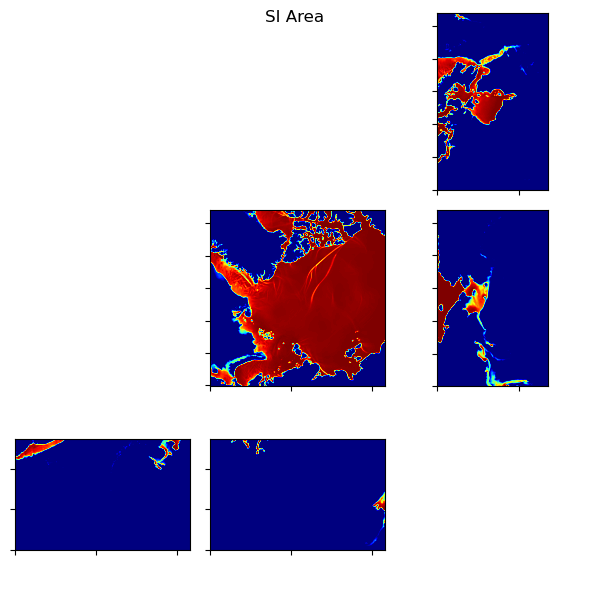

In [72]:
fig,axs = plt.subplots(3,3, figsize=[6,6])
ax = axs.ravel()
ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].imshow(SIarea_faces[5], origin='lower', cmap='jet', vmin=0, vmax=1)
ax[3].set_axis_off()
ax[4].imshow(SIarea_faces[3], origin='lower', cmap='jet', vmin=0, vmax=1)
ax[5].imshow(SIarea_faces[4], origin='lower', cmap='jet', vmin=0, vmax=1)
ax[6].imshow(SIarea_faces[1], origin='lower', cmap='jet', vmin=0, vmax=1)
ax[7].imshow(SIarea_faces[2], origin='lower', cmap='jet', vmin=0, vmax=1)
ax[8].set_axis_off()

for ax in ax:
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    
plt.tight_layout()
plt.suptitle("SI Area");

In [25]:
SIarea_faces_HH = combine_sassie_N1_faces_to_HHv2_2D(SIarea_faces)

Text(0.5, 1.0, 'SI Area - HH')

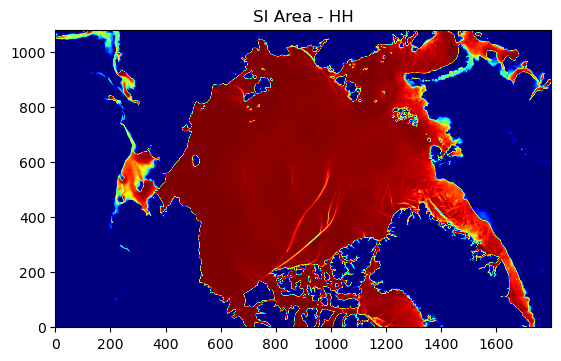

In [80]:
plt.imshow(SIarea_faces_HH, origin='lower', cmap='jet', vmin=0, vmax=1)
plt.title("SI Area - HH")

In [23]:
etan_faces_HH = combine_sassie_N1_faces_to_HHv2_2D(etan_faces)

In [84]:
etan_faces_HH.shape

(1080, 1800)

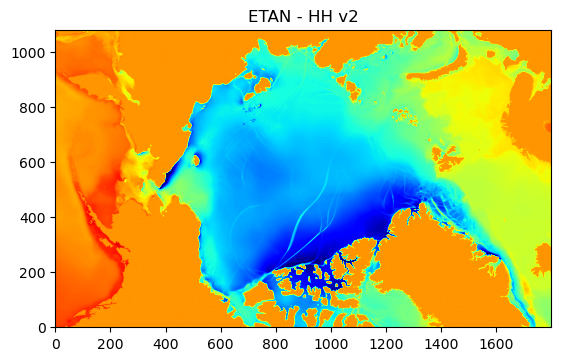

In [86]:
plt.imshow(etan_faces_HH, origin='lower', cmap='jet', vmin=-3, vmax=1)
plt.title("ETAN - HH v2");

## 3D fields

In [8]:
(226*365*7/1000)*6

3464.58

In [31]:
sassie_1080_data_dir = Path('/Users/mzahn/data/SASSIE/SASSIE_examples/')
ocean_3d_filename = 'ocean_state_3D_day_mean/ocean_state_3D_day_mean.0007547040.data'

# nk=180 because there are two variables each with 90 vertical levels
ocean3d_compact, ocean3d_time_level = load_sassie_N1_field(sassie_1080_data_dir, ocean_3d_filename, nk=180)

load_binary_array: loading file /Users/mzahn/data/SASSIE/SASSIE_examples/ocean_state_3D_day_mean/ocean_state_3D_day_mean.0007547040.data
load_binary_array: data array shape  (180, 3800, 1080)
load_binary_array: data array type  >f4


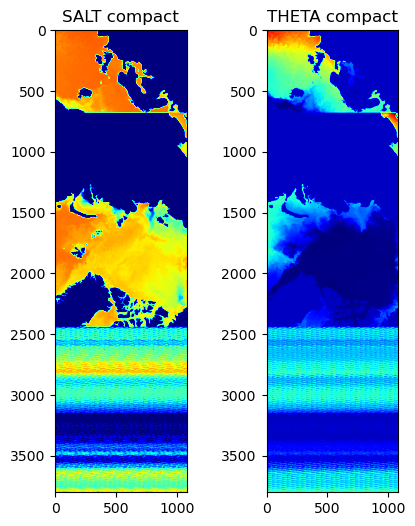

In [36]:
fig,axs = plt.subplots(1,2, figsize=[5,6])
axs[0].imshow(ocean3d_compact[0,:,:], origin='lower', cmap='jet')
axs[1].imshow(ocean3d_compact[90,:,:], origin='lower', cmap='jet')

axs[0].set_title("SALT compact")
axs[1].set_title("THETA compact")

for ax in axs:
    ax.invert_yaxis()

In [38]:
salt_faces  = sassie_n1_compact_to_faces_3D(ocean3d_compact[0:90,:,:])
theta_faces = sassie_n1_compact_to_faces_3D(ocean3d_compact[90:180,:,:])

salt_faces[1].shape

(90, 680, 1080)

In [41]:
def plot_ecco_map_3D(faces_ds, vmin_ds=None, vmax_ds=None, cmap='jet', title=" "):
    
    if vmin_ds is None:
        vmin_ds = faces_ds[3].min()
        vmax_ds = faces_ds[3].max()
    
    fig,axs = plt.subplots(3,3, figsize=[7,7])
    ax = axs.ravel()
    ax[0].set_axis_off()
    ax[1].set_axis_off()
    ax2_cmap = ax[2].imshow(faces_ds[5][0,:,:], origin='lower', cmap=cmap, vmin=vmin_ds, vmax=vmax_ds)
    
    ax[3].set_axis_off()
    ax[4].imshow(faces_ds[3][0,:,:], origin='lower', cmap=cmap, vmin=vmin_ds, vmax=vmax_ds)
    ax[5].imshow(faces_ds[4][0,:,:], origin='lower', cmap=cmap, vmin=vmin_ds, vmax=vmax_ds)
    ax[5].axvline(x=535, color='k', linestyle='dashed', linewidth=2)
    
    ax[6].imshow(faces_ds[1][0,:,:], origin='lower', cmap=cmap, vmin=vmin_ds, vmax=vmax_ds)
    ax[6].axhline(y=680-185, color='k', linestyle='dashed', linewidth=2)
    ax[7].imshow(faces_ds[2][0,:,:], origin='lower', cmap=cmap, vmin=vmin_ds, vmax=vmax_ds)
    ax[8].set_axis_off()
    
    axins = inset_axes(
    ax[2],
    width="10%",  # width: 5% of parent_bbox width
    height="100%",
    loc="upper left",
    bbox_to_anchor=(1.2, 0., 1, 1),
    bbox_transform=ax[2].transAxes,
    borderpad=0)
    cb = fig.colorbar(ax2_cmap, cax=axins)
    
    for ax in ax:
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        
    # plt.tight_layout()
    plt.suptitle(title);
    
    plt.show()

In [43]:
salt_faces_HH  = combine_sassie_N1_faces_to_HHv2_3D(salt_faces)
theta_faces_HH = combine_sassie_N1_faces_to_HHv2_3D(theta_faces)

print(salt_faces_HH.shape)
print(theta_faces_HH.shape)

(90, 1080, 1800)
(90, 1080, 1800)


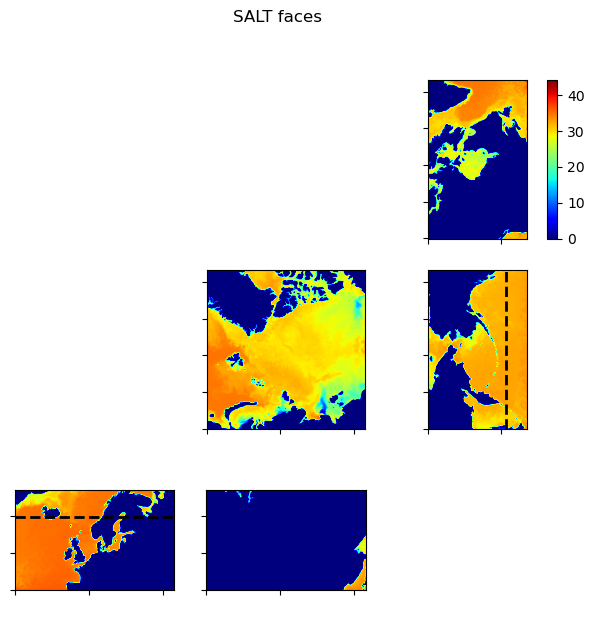

In [54]:
plot_ecco_map_3D(salt_faces, vmin_ds=None, vmax_ds=None, cmap='jet', title="SALT faces")

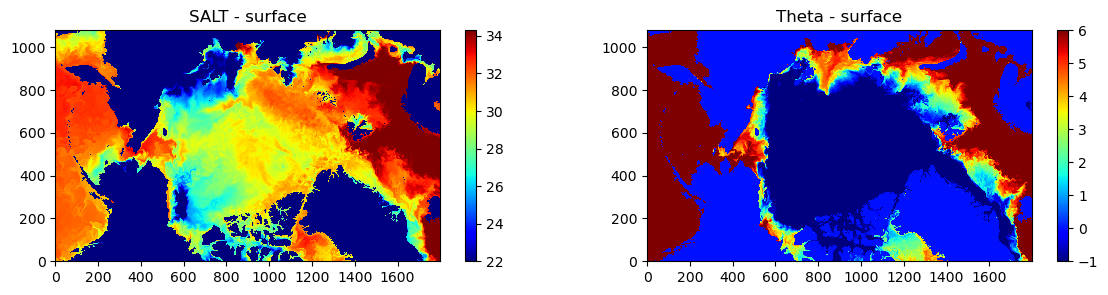

In [70]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=[14,3])
plot_sassie_HHv2_3D(salt_faces, depth_level=3, axs=ax1,cmap='jet',vmin=22, vmax=34.3)
plot_sassie_HHv2_3D(theta_faces, depth_level=3, axs=ax2,cmap='jet',vmin=-1, vmax=6)
ax1.set_title("SALT - surface")
ax2.set_title("Theta - surface");

# Create routine to process files

In [21]:
sassie_llc1080_data_dir = Path('/Users/mzahn/data/SASSIE/SASSIE_examples/')
ocean_3d_filename = 'ocean_state_3D_day_mean/ocean_state_3D_day_mean.0005790000/ocean_state_3D_day_mean.0005796720.data'

# nk=180 because there are two variables each with 90 vertical levels
ocean3d_compact, ocean3d_time_level = load_sassie_N1_field(sassie_llc1080_data_dir, ocean_3d_filename, nk=180)

load_binary_array: loading file /Users/mzahn/data/SASSIE/SASSIE_examples/ocean_state_3D_day_mean/ocean_state_3D_day_mean.0005790000/ocean_state_3D_day_mean.0005796720.data
load_binary_array: data array shape  (180, 3800, 1080)
load_binary_array: data array type  >f4


In [55]:
salt_faces  = sassie_n1_compact_to_faces_3D(ocean3d_compact[0:90,:,:])
theta_faces = sassie_n1_compact_to_faces_3D(ocean3d_compact[90:180,:,:])

In [57]:
salt_faces_HHv2  = combine_sassie_N1_faces_to_HHv2_3D(salt_faces)
theta_faces_HHv2 = combine_sassie_N1_faces_to_HHv2_3D(theta_faces)

Open geometry file

In [27]:
sassie_n1_geometry_ds = xr.open_dataset('/Users/mzahn/data/SASSIE/GRID_GEOMETRY_SASSIE_HH_V1r1_native_llc1080.nc')

In [33]:
salt_HH_da = make_3D_HHv2_da(salt_faces_HHv2, sassie_n1_geometry_ds, da_name='SALT', k_face='center')

In [ ]:
salt_HH_da

In [276]:
mds_var_dir = Path('/Users/mzahn/data/SASSIE/SASSIE_examples/ocean_state_3D_day_mean/ocean_state_3D_day_mean.0005790000/')
mds_file = 'ocean_state_3D_day_mean'
mds_output_dir = Path('/Users/mzahn/data/SASSIE/SASSIE_netcdfs/ocean_state_3D_day_mean/')

time_steps = ecco.get_time_steps_from_mds_files(mds_var_dir, mds_file, less_output=True)

get time steps


In [386]:
ocean3d_time_level

5796720

In [446]:
timestamp_from_iter_num(iter_num)

numpy.datetime64('2014-01-06T16:00:00.000000')

In [53]:
time_steps

[5796720, 5797440, 5798160, 5798880, 5799600]

In [182]:
meta_file = pd.read_csv(meta_files[0], delimiter=";", header = None).to_dict()[0]

In [184]:
meta_file

{0: ' nDims = [   3 ]',
 1: ' dimList = [',
 2: '         40,         1,        40,',
 3: '     102600,         1,    102600,',
 4: '         90,         1,        90',
 5: ' ]',
 6: " dataprec = [ 'float32' ]",
 7: ' nrecords = [          2 ]',
 8: ' timeStepNumber = [    5796720 ]',
 9: ' timeInterval = [  6.955200000000E+08  6.956064000000E+08 ]',
 10: ' missingValue = [ -9.99000000000000E+02 ]',
 11: ' nFlds = [    2 ]',
 12: ' fldList = {',
 13: " 'SALT    ' 'THETA   '",
 14: ' }'}

In [308]:
## model output directories
sassie_llc1080_data_dir = '/Users/mzahn/data/SASSIE/SASSIE_examples/'

## ocean 3D data directory
ocean_3d_file_dir = 'ocean_state_3D_day_mean/'
ocean_3d_file_subdir = 'ocean_state_3D_day_mean.0005790000/' # includes 14 data files from compressed file

## where to save netCDFs with directories for each variable
mds_output_dir = '/Users/mzahn/data/SASSIE/SASSIE_netcdfs/'

## identify data directories
data_dir = Path(sassie_llc1080_data_dir + ocean_3d_file_dir + ocean_3d_file_subdir) # using ocean 3d as first example
data_files = np.sort(list(data_dir.glob(mds_file + '*data')))

## identify number of fields in dataset
meta_files = np.sort(list(data_dir.glob(mds_file + '*meta')))
nFlds = [int(i) for i in meta_file[11].split('=')[-1].split() if i.isdigit()][0] # extract number from string
fldList = meta_file[13]

In [593]:
## loop through each time step ------

## loop through files
for file in data_files[0:2]:
    print('loading file: ', file)
    
    filename = str(file).split('/')[-1]
    
    if nFlds == 2:
        ## process binary data to compact format
        # nk=180 because there are two variables each with 90 vertical levels
        var1_compact, iter_num = load_sassie_N1_field(str(data_dir), filename, nk=90, skip=0)
        var2_compact, iter_num = load_sassie_N1_field(str(data_dir), filename, nk=90, skip=90)
        
        ## convert compact format to 5 faces
        var1_faces = sassie_n1_compact_to_faces_3D(data_compact[0:90,:,:]) # process first variable
        var2_faces = sassie_n1_compact_to_faces_3D(data_compact[90:180,:,:]) # process first variable
        
        ## convert faces to HHv2 Arctic rectangle
        var1_HHv2 = combine_sassie_N1_faces_to_HHv2_3D(var1_faces)
        var2_HHv2 = combine_sassie_N1_faces_to_HHv2_3D(var2_faces)
        
        ## Create DataArrays from HHv2
        var1_name = meta_file[13].split()[0].strip("' \t")
        var2_name = meta_file[13].split()[2].strip("' \t")
        
        ## add timestamp to dataset
        timestamp = timestamp_from_iter_num(iter_num)
        
        var1_HHv2_da = make_3D_HHv2_da(var1_HHv2, sassie_n1_geometry_ds, timestamp, da_name=var1_name, k_face='center')
        var2_HHv2_da = make_3D_HHv2_da(var2_HHv2, sassie_n1_geometry_ds, timestamp, da_name=var2_name, k_face='center')
        
        ## convert DataArrays to datasets
        var1_HHv2_ds = var1_HHv2_da.to_dataset()
        var2_HHv2_ds = var2_HHv2_da.to_dataset()

        # save netCDF files
        mds_output_dir_var1 = Path(mds_output_dir + ocean_3d_file_dir + var1_name)
        mds_output_dir_var2 = Path(mds_output_dir + ocean_3d_file_dir + var2_name)
        
        mds_output_dir_var1.mkdir(parents=True, exist_ok=True) # create output directory if it doesn't already exist
        mds_output_dir_var2.mkdir(parents=True, exist_ok=True)
        
        encoding_var1 = create_encoding(var1_HHv2_ds, output_array_precision = np.float32)
        encoding_var2 = create_encoding(var2_HHv2_ds, output_array_precision = np.float32)
        
        var1_filename_netcdf = "SASSIE_HH_" + var1_name + "_" + str(time_level) + ".nc"
        var2_filename_netcdf = "SASSIE_HH_" + var2_name + "_" + str(time_level) + ".nc"
        
        var1_HHv2_ds.to_netcdf(mds_output_dir_var1 / var1_filename_netcdf, encoding = encoding_var1)
        var2_HHv2_ds.to_netcdf(mds_output_dir_var2 / var2_filename_netcdf, encoding = encoding_var2)
        
        var1_HHv2_ds.close()
        var2_HHv2_ds.close()

loading file:  /Users/mzahn/data/SASSIE/SASSIE_examples/ocean_state_3D_day_mean/ocean_state_3D_day_mean.0005790000/ocean_state_3D_day_mean.0005796720.data
load_binary_array: loading file /Users/mzahn/data/SASSIE/SASSIE_examples/ocean_state_3D_day_mean/ocean_state_3D_day_mean.0005790000/ocean_state_3D_day_mean.0005796720.data
load_binary_array: data array shape  (180, 3800, 1080)
load_binary_array: data array type  >f4

... creating variable encodings

... creating coordinate encodings

... creating variable encodings

... creating coordinate encodings
loading file:  /Users/mzahn/data/SASSIE/SASSIE_examples/ocean_state_3D_day_mean/ocean_state_3D_day_mean.0005790000/ocean_state_3D_day_mean.0005797440.data
load_binary_array: loading file /Users/mzahn/data/SASSIE/SASSIE_examples/ocean_state_3D_day_mean/ocean_state_3D_day_mean.0005790000/ocean_state_3D_day_mean.0005797440.data
load_binary_array: data array shape  (180, 3800, 1080)
load_binary_array: data array type  >f4

... creating variab

Open tar.gz files

In [4]:
## open example file 
# targz_file = tarfile.open('./data/tar_gz_files/seaice_state_day_mean.0005810000.tar.gz') 
targz_file = tarfile.open('/Users/mzahn/data/SASSIE/SASSIE_examples/ocean_state_2D_day_mean/ocean_state_2D_day_mean.0005800000.tar.gz')

## extracting file to produce *.data and *.meta files
targz_file.extractall('/Users/mzahn/data/SASSIE/SASSIE_examples/ocean_state_2D_day_mean/data') 
targz_file.close() 

1) Grab all files in directory
2) Extract timestamp from each filename and then you will loop through each filename
3) Process each file in a loop and output netcdf in new dir

In [41]:
def add_geo_metadata(tmp_da):
    if 'XC' in list(tmp_da.coords):
        tmp_da['XC'].attrs['long_name'] = 'longitude of cell center'
        tmp_da['XC'].attrs['standard_name'] = 'longitude'
        tmp_da['XC'].attrs['units'] = 'degrees_east'
        
    if 'YC' in list(tmp_da.coords):
        tmp_da['YC'].attrs['long_name'] = 'latitude of cell center'
        tmp_da['YC'].attrs['standard_name'] = 'latitude'
        tmp_da['YC'].attrs['units'] = 'degrees_north'

    if 'i' in list(tmp_da.coords):
        tmp_da['i'].attrs['axis']  = 'X'
        tmp_da['i'].attrs['swap_dim']  = 'XC'

    if 'j' in list(tmp_da.coords):
        tmp_da['j'].attrs['axis']  = 'Y'
        tmp_da['j'].attrs['swap_dim']  = 'YC'

    if 'i_g' in list(tmp_da.coords):
        tmp_da['i_g'].attrs['axis']  = 'X'      
        
    if 'j_g' in list(tmp_da.coords):
        tmp_da['j_g'].attrs['axis']  = 'Y'        
    return tmp_da


In [49]:
import cartopy.crs as ccrs

In [53]:
SIarea_da

<xarray.DataArray 'SIarea' (j: 1080, i: 1800)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
    XC       (j, i) float32 -128.0 -128.0 -128.0 -128.0 ... 51.96 51.96 51.96
    YC       (j, i) float32 48.68 48.73 48.78 48.83 ... 63.44 63.41 63.37 63.34
Dimensions without coordinates: j, i

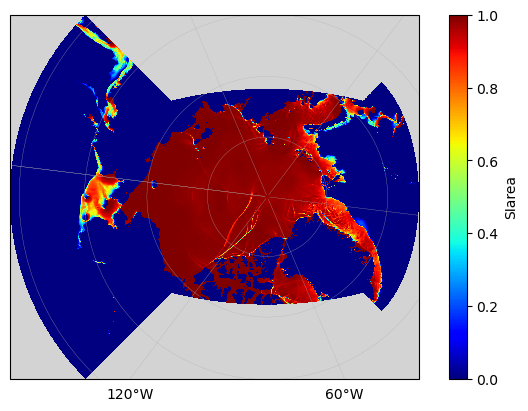

In [51]:
fig = plt.figure(figsize=(7,4), constrained_layout=True)
ax1 = fig.add_subplot(1,1,1, projection=ccrs.NorthPolarStereo(central_longitude = -83))
# ax1.set_extent([-75, -48, 68, 78], ccrs.PlateCarree())

SIarea_da.plot(x='XC',y='YC',ax=ax1,vmin=0,vmax=1,cmap='jet',transform=ccrs.PlateCarree())

ax1.set_facecolor('lightgray')
# ax1.set_title("depth=" + str(theta_350m.depth.values))
gl = ax1.gridlines(crs=ccrs.PlateCarree(), linewidth=0.2,draw_labels=True,x_inline=False, y_inline=False,\
                  xpadding=6,ypadding=6,rotate_labels=False)
gl.top_labels = False
gl.right_labels = False
gl.left_labels = False